In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
offers = pd.read_csv(r'../datasets/data_offers.csv')
orders = pd.read_csv(r'../datasets/data_orders.csv')

### EDA

In [3]:
print("Shape:", offers.shape)
print("\nColumns:")
print(offers.columns.tolist())

Shape: (334363, 2)

Columns:
['order_gk', 'offer_id']


In [4]:
print("Shape:", orders.shape)
print("\nColumns:")
print(orders.columns.tolist())

Shape: (10716, 8)

Columns:
['order_datetime', 'origin_longitude', 'origin_latitude', 'm_order_eta', 'order_gk', 'order_status_key', 'is_driver_assigned_key', 'cancellations_time_in_seconds']


In [5]:
print("\nData types (offers):")
print(offers.dtypes)


Data types (offers):
order_gk    int64
offer_id    int64
dtype: object


In [6]:
print("\nData types (orders):")
print(orders.dtypes)


Data types (orders):
order_datetime                    object
origin_longitude                 float64
origin_latitude                  float64
m_order_eta                      float64
order_gk                           int64
order_status_key                   int64
is_driver_assigned_key             int64
cancellations_time_in_seconds    float64
dtype: object


In [7]:
print("\nMissing values(offers):")
print(offers.isna().sum())


Missing values(offers):
order_gk    0
offer_id    0
dtype: int64


In [8]:
print("\nMissing values(orders):")
print(orders.isna().sum())


Missing values(orders):
order_datetime                      0
origin_longitude                    0
origin_latitude                     0
m_order_eta                      7902
order_gk                            0
order_status_key                    0
is_driver_assigned_key              0
cancellations_time_in_seconds    3409
dtype: int64


### Missing Values Pattern (Summary)

The missing-value pattern reflects the system’s business logic:

- **`m_order_eta` is missing only for system-reject orders (status = 9).**  
  System-cancelled orders never reach driver assignment, so no ETA is generated.

- **`cancellations_time_in_seconds` is missing only for customer-cancel orders (status = 4).**  
  Cancellation time is recorded only when the customer actively cancels.

**Conclusion:**  
Missing ETA → system cancel  
Missing cancellation time → customer cancel

This is expected behavior, not a data-quality issue.


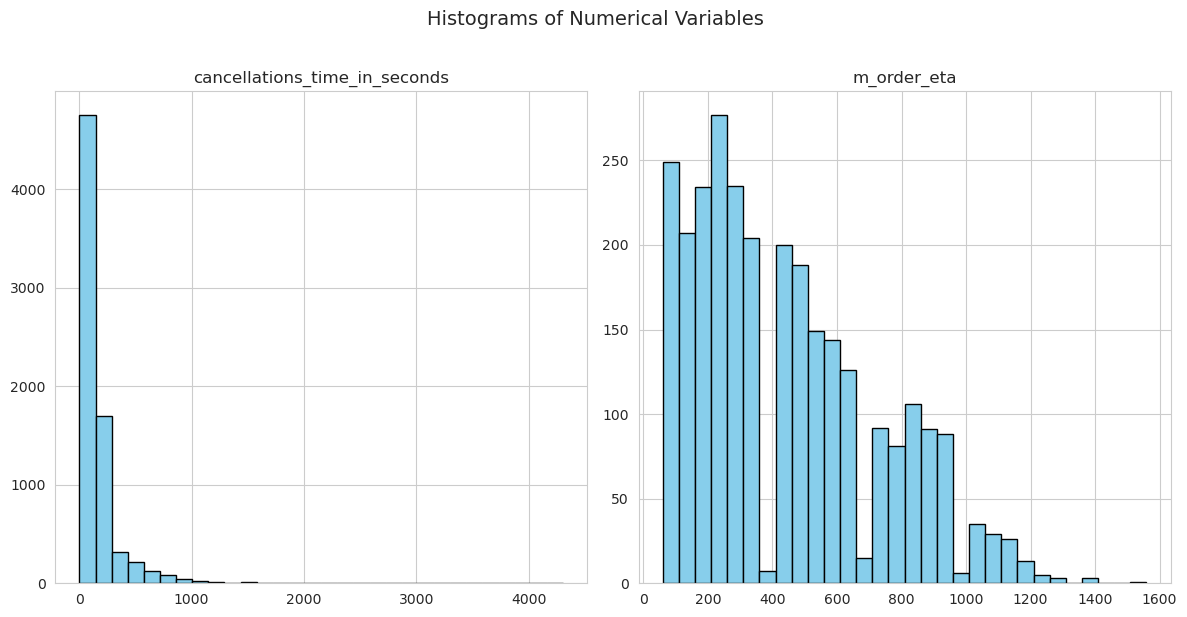

In [9]:
# Histograms for numerical variables
sns.set_style("whitegrid")

numeric_cols = orders[['cancellations_time_in_seconds', 'm_order_eta']]

numeric_cols.hist(
    figsize=(12, 6),
    bins=30,             
    edgecolor='black',    
    color='skyblue'    
)

plt.suptitle("Histograms of Numerical Variables", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## Task 1 — Failure Reasons Distribution

In [10]:
orders_failures = orders.copy()

# classify failure reasons based on status & driver_assigned
def classify_failure(row):
    status = row['order_status_key']
    driver_assigned = row['is_driver_assigned_key']
    
    # status = 4 → customer cancel
    if status == 4:
        if driver_assigned == 1:
            return 'Cancel after assignment'
        elif driver_assigned == 0:
            return 'Cancel before assignment'
        else:
            return 'Cancel (unknown driver status)'
    
    # status = 9 → system reject
    elif status == 9:
        return 'System reject'
    
    else:
        return 'Other / Unknown'

orders_failures['failure_type'] = orders_failures.apply(classify_failure, axis=1)


In [11]:
failure_summary = (
    orders_failures['failure_type']
    .value_counts(dropna=False)
    .rename_axis('failure_type')
    .reset_index(name='count')
)

total_failures = failure_summary['count'].sum()
failure_summary['percentage'] = failure_summary['count'] / total_failures * 100

print("Failure type distribution:")
print(failure_summary)

Failure type distribution:
               failure_type  count  percentage
0  Cancel before assignment   4496   41.955954
1             System reject   3409   31.812243
2   Cancel after assignment   2811   26.231803


In [12]:
cat_order = [
    'Cancel before assignment',
    'Cancel after assignment',
    'System reject',
]
orders_failures['failure_type'] = pd.Categorical(orders_failures['failure_type'], categories=cat_order, ordered=True)

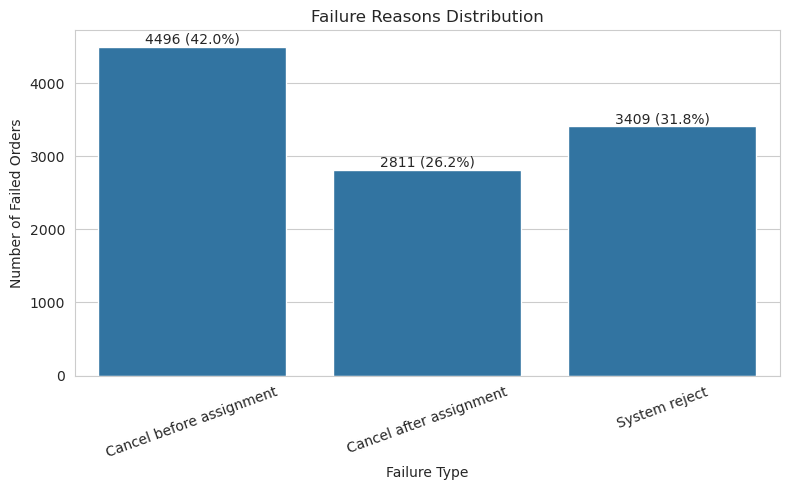

In [13]:
# plot bar charts
sns.set_style("whitegrid")

plt.figure(figsize=(8, 5))
ax = sns.barplot(
    data=failure_summary,
    x='failure_type',
    y='count',
    order=cat_order  
)

for p in ax.patches:
    height = p.get_height()
    percentage = height / total_failures * 100
    ax.annotate(
        f'{int(height)} ({percentage:.1f}%)',
        (p.get_x() + p.get_width() / 2., height),
        ha='center', va='bottom',
        fontsize=10
    )
plt.title('Failure Reasons Distribution')
plt.xlabel('Failure Type')
plt.ylabel('Number of Failed Orders')
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

Cancel-before-assignment represents the largest share of failed orders, accounting for 42% of all cancellations, while cancel-after-assignment contributes only 26.2%.
This pattern suggests that many customers cancel very shortly after submitting the order—before the system has time to assign a driver. One possible explanation is that these users realize they need to modify their order details (e.g., pickup location, timing) and therefore cancel immediately.
A useful next step would be to investigate whether these customers tend to place a new order shortly after cancelling. If this behavior is common, the product team could consider adding an “Edit Order” feature to reduce unnecessary cancellations and improve user experience.

On the other hand, cancellations after driver assignment occur less frequently. This implies that the speed of driver assignment may play a critical role in reducing cancellations.
Enhancing matching efficiency—such as improving driver availability in high-demand areas or optimizing dispatch algorithms—could reduce the waiting time before assignment and ultimately lower the overall cancellation rate.

## Task 2 — Failed Orders by Hour

In [14]:
orders_failures['order_hour'] = pd.to_datetime(
    orders_failures['order_datetime'], 
    format='%H:%M:%S'
).dt.hour

hourly_counts = (
    orders_failures.groupby('order_hour')
      .size()
      .rename('count')
      .reset_index()
      .sort_values('order_hour')
)

total_failed = hourly_counts['count'].sum()
hourly_counts['percentage'] = hourly_counts['count'] / total_failed * 100

print("Failed orders by hour:")
print(hourly_counts)

Failed orders by hour:
    order_hour  count  percentage
0            0    683    6.373647
1            1    471    4.395297
2            2    555    5.179171
3            3    513    4.787234
4            4    152    1.418440
5            5     67    0.625233
6            6    159    1.483763
7            7    447    4.171333
8            8   1082   10.097051
9            9    412    3.844718
10          10    170    1.586413
11          11    193    1.801045
12          12    256    2.388951
13          13    366    3.415454
14          14    256    2.388951
15          15    439    4.096678
16          16    356    3.322135
17          17    541    5.048526
18          18    414    3.863382
19          19    317    2.958193
20          20    469    4.376633
21          21    846    7.894737
22          22    716    6.681598
23          23    836    7.801418


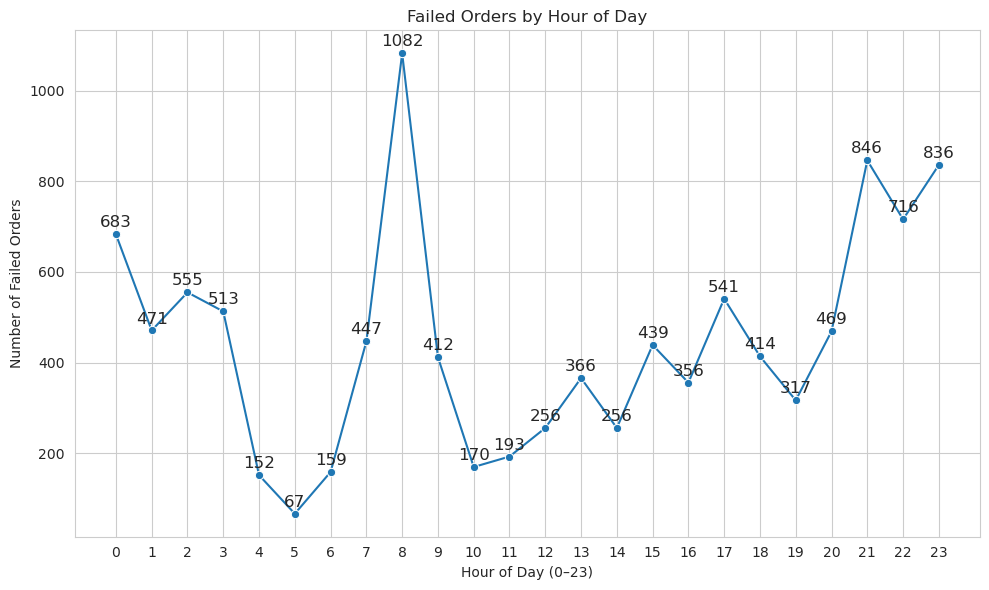

In [15]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

ax = sns.lineplot(
    data=hourly_counts,
    x='order_hour',
    y='count',
    marker='o'
)


for x, y in zip(hourly_counts['order_hour'], hourly_counts['count']):
    ax.annotate(
        f'{y}',
        (x, y),
        textcoords="offset points",
        xytext=(0, 5),
        ha='center',
        fontsize=12
    )

plt.title('Failed Orders by Hour of Day')
plt.xlabel('Hour of Day (0–23)')
plt.ylabel('Number of Failed Orders')
plt.xticks(range(0, 24))  
plt.tight_layout()
plt.show()

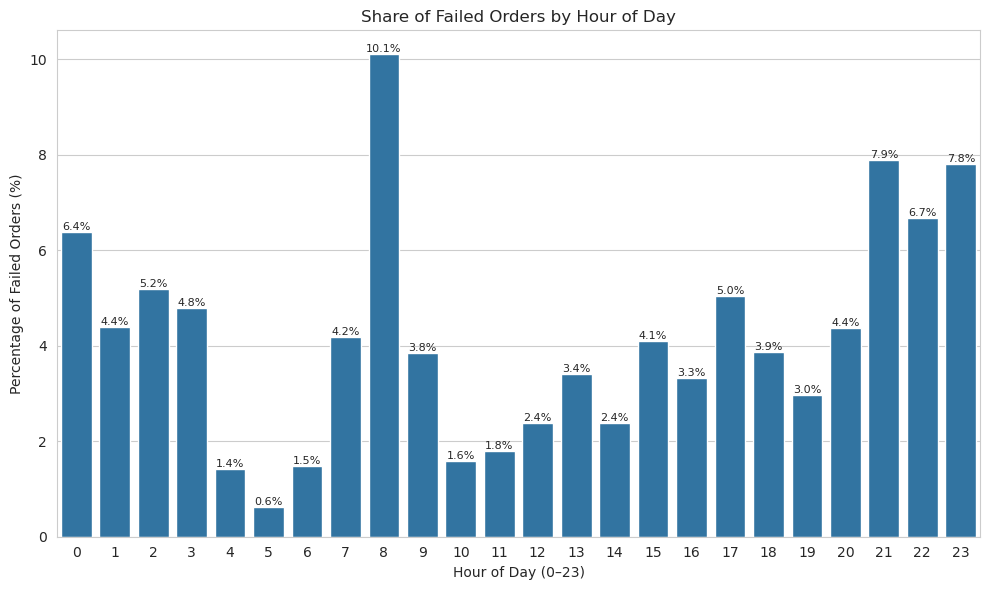

In [16]:
plt.figure(figsize=(10, 6))

ax = sns.barplot(
    data=hourly_counts,
    x='order_hour',
    y='percentage'
)

for p in ax.patches:
    height = p.get_height()
    ax.annotate(
        f'{height:.1f}%',
        (p.get_x() + p.get_width() / 2., height),
        ha='center', va='bottom',
        fontsize=8
    )

plt.title('Share of Failed Orders by Hour of Day')
plt.xlabel('Hour of Day (0–23)')
plt.ylabel('Percentage of Failed Orders (%)')
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()

In [17]:
focus_hours = [8, 21, 22, 23]

hour_reason_counts = (
    orders_failures[orders_failures['order_hour'].isin(focus_hours)]
    .groupby(['order_hour', 'failure_type'])
    .size()
    .reset_index(name='count')
)

hour_reason_counts['hour_total'] = (
    hour_reason_counts.groupby('order_hour')['count'].transform('sum')
)

hour_reason_counts['percentage'] = (
    hour_reason_counts['count'] / hour_reason_counts['hour_total'] * 100
)

print("Failure reason distribution within focus hours:")
print(hour_reason_counts.sort_values(['order_hour', 'failure_type']))

pivot_pct = hour_reason_counts.pivot_table(
    index='order_hour',
    columns='failure_type',
    values='percentage'
)

print("\nPercentage table (rows = hour, cols = failure_type):")
print(pivot_pct)



Failure reason distribution within focus hours:
    order_hour              failure_type  count  hour_total  percentage
0            8  Cancel before assignment    413        1082   38.170055
1            8   Cancel after assignment    314        1082   29.020333
2            8             System reject    355        1082   32.809612
3           21  Cancel before assignment    448         846   52.955083
4           21   Cancel after assignment    102         846   12.056738
5           21             System reject    296         846   34.988180
6           22  Cancel before assignment    326         716   45.530726
7           22   Cancel after assignment    149         716   20.810056
8           22             System reject    241         716   33.659218
9           23  Cancel before assignment    378         836   45.215311
10          23   Cancel after assignment    156         836   18.660287
11          23             System reject    302         836   36.124402

Percentage tabl

/tmp/ipykernel_487918/3131205285.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['order_hour', 'failure_type'])
/tmp/ipykernel_487918/3131205285.py:21: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_pct = hour_reason_counts.pivot_table(


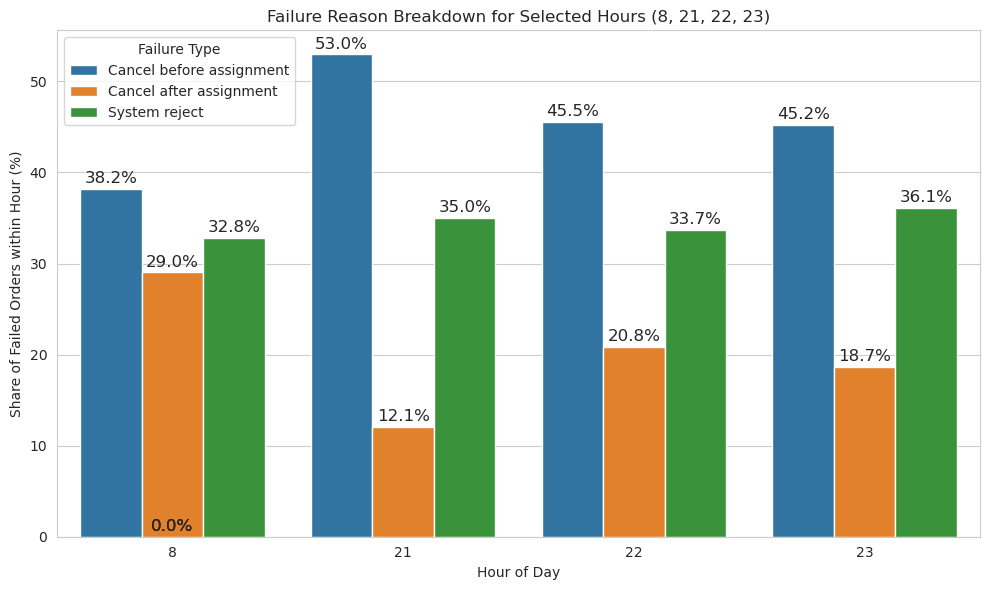

In [18]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

ax = sns.barplot(
    data=hour_reason_counts,
    x='order_hour',
    y='percentage',
    hue='failure_type'
)

for p in ax.patches:
    height = p.get_height()
    ax.annotate(
        f'{height:.1f}%',
        (p.get_x() + p.get_width() / 2., height),
        ha='center', va='bottom',
        fontsize=12,
        xytext=(0, 2),
        textcoords='offset points'
    )

plt.title('Failure Reason Breakdown for Selected Hours (8, 21, 22, 23)')
plt.xlabel('Hour of Day')
plt.ylabel('Share of Failed Orders within Hour (%)')
plt.legend(title='Failure Type')
plt.tight_layout()
plt.show()

We observe that the cancellation share at 8 AM is noticeably higher than at other hours. A plausible explanation is that 8 AM corresponds to the morning commute peak, during which users are rushing to work and therefore have lower patience and reduced tolerance for waiting times. Passenger demand is also elevated at this hour, meaning the system may not be able to assign drivers quickly enough.

Moreover, the pressure of not being late leads commuters to make decisions rapidly and switch to alternative transportation options such as metro or buses. As a result, even when a driver has already been assigned, users may still choose to cancel the order if the estimated arrival time seems too long or uncertain.

To address the unusually high cancellation rate observed at 8 AM, we suggest:

1. Improve ETA accuracy during peak hours.
Because commuters at 8 AM are highly sensitive to even small increases in waiting time, providing a more accurate and reliable ETA estimation can help reduce cancellations. Enhancing the ETA model specifically for peak-hour traffic conditions—by incorporating real-time congestion data, historical morning patterns, and driver density—can lower user uncertainty and prevent users from abandoning their rides after assignment.

2. Introduce peak-hour driver incentives between 7–9 AM.
The elevated cancellation rate at 8 AM is strongly tied to an imbalance between high passenger demand and limited driver availability. Implementing time-specific incentives can increase the number of active drivers during the morning rush, improving assignment speed and reducing wait times. A stronger supply presence during this window directly addresses one of the root causes of early-stage cancellations.

3. Streamline early-stage matching to assign drivers more quickly.
Given the urgency of commuters’ travel needs, even minor delays in driver assignment significantly increase the likelihood of cancellation. Optimizing the initial matching logic—such as reducing early filtering constraints or allowing a faster assignment of the nearest available driver—can help ensure that users receive a match before deciding to switch to alternative transport modes. Faster assignment is especially critical at 8 AM, when user patience is at its lowest.

## Task 3 — Average Time to Cancellation (With vs Without Driver Assignment)

In [19]:
df_task3 = orders_failures[orders_failures["failure_type"].isin([
    'Cancel before assignment', 
    'Cancel after assignment'
])]

In [20]:
# remove outliers
upper = df_task3['cancellations_time_in_seconds'].quantile(0.99)
df_task3 = df_task3[df_task3['cancellations_time_in_seconds'] <= upper]

In [21]:
task3_result = ( df_task3.groupby(['order_hour', 'is_driver_assigned_key']) ['cancellations_time_in_seconds'] .mean() .reset_index() )

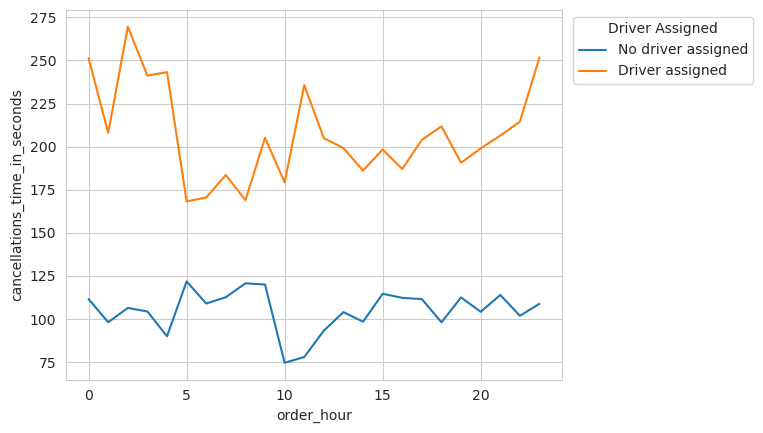

In [22]:
task3_result['driver_assigned'] = task3_result['is_driver_assigned_key'].map({
    0: 'No driver assigned',
    1: 'Driver assigned'
})

ax = sns.lineplot(
    data=task3_result,
    x='order_hour',
    y='cancellations_time_in_seconds',
    hue='driver_assigned'
)

ax.legend(
    title='Driver Assigned',
    loc='upper right',          
    bbox_to_anchor=(1.4, 1),  
    frameon=True              
)


### Insights from Cancellation Time Analysis

We observe several notable patterns from the cancellation-time behavior:

1. **Customers with a driver assigned wait significantly longer before cancelling**—typically **3 to 4 minutes**, compared to only **1 to 2 minutes** for orders without a driver assignment.  
   This suggests that once users see a confirmed driver, their commitment increases and they tolerate longer wait times.

2. **During late-night hours (23:00–04:00), customers show even higher willingness to wait when a driver is assigned.**  
   A likely explanation is the limited availability of alternative transportation options at night, making users more patient even when ETAs fluctuate.

3. **Around 10:00 AM, customers without a driver assignment cancel much faster.**  
   Several factors may contribute to this behavior:  
   - **Lower urgency:** Unlike the morning commute, users at 10 AM may have more flexible schedules.  
   - **Lower demand density:** Requests may come from more dispersed locations, slowing assignment and prompting early cancellation.  
   - **More alternatives available:** Public transportation or walking are more viable in mid-morning.  
   - **Perceived inefficiency:** Users may interpret slow assignment as “no drivers nearby,” leading to quicker cancellations.

---

### Overall Conclusion

Across all hours, customers **consistently wait longer when a driver is assigned**, whereas orders without driver assignment tend to be cancelled early.  
This highlights the importance of **accelerating the initial driver-assignment process**.  
Even if reassignment occurs later, reducing the waiting gap before the first assignment can meaningfully decrease the overall cancellation rate.


## Task 4 — Average ETA Distribution by Hour

In [23]:
df_task4 = orders_failures[orders_failures['m_order_eta'].notna()].copy()

In [24]:
eta_hourly = (
    df_task4.groupby('order_hour')['m_order_eta']
            .mean()
            .reset_index()
)

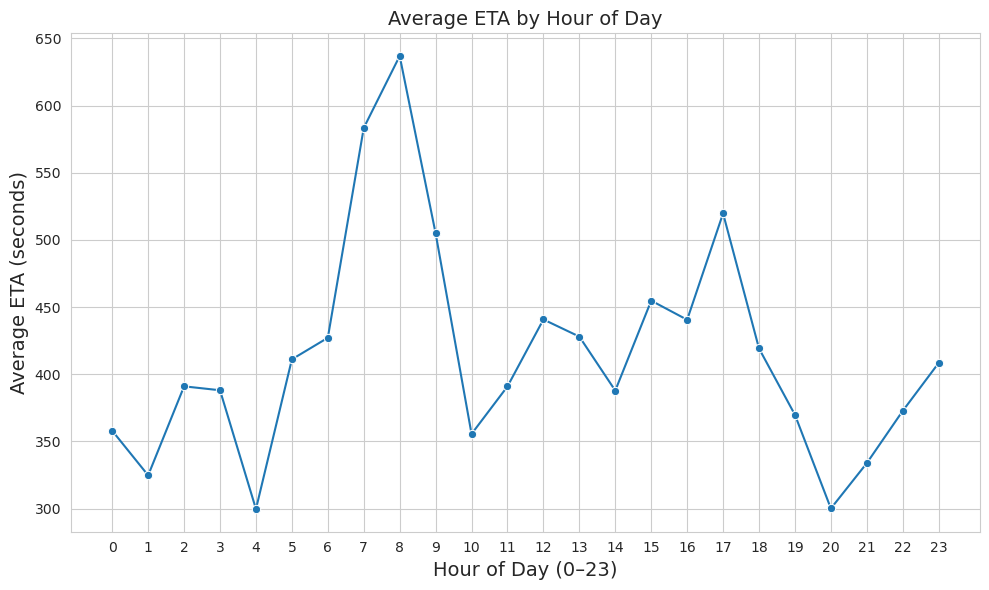

In [25]:
# Line Chart
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

sns.lineplot(
    data=eta_hourly,
    x='order_hour',
    y='m_order_eta',
    marker='o'
)

plt.title("Average ETA by Hour of Day", fontsize=14)
plt.xlabel("Hour of Day (0–23)", fontsize=14)
plt.ylabel("Average ETA (seconds)", fontsize=14)
plt.xticks(range(24))
plt.tight_layout()
plt.show()

According to the line chart, ETA is highest around 7–8 AM and again around 5 PM. These peaks correspond to the morning and evening rush hours, during which travel demand increases sharply. As a result, driver supply becomes insufficient, matching takes longer, and customers experience extended waiting times before a driver is assigned.

To mitigate long ETAs during these peak periods, several strategies can be considered:

1. Increase driver supply through time-based incentives (e.g., morning and evening peak-hour bonuses) to encourage more drivers to be online when demand surges.

2. Improve demand forecasting to pre-position drivers in high-volume areas before the rush begins.

3. Enhance the matching algorithm to prioritize faster assignments during rush hours, such as relaxing matching constraints or expanding the matching radius temporarily.

4. Refine ETA prediction models to incorporate real-time traffic and congestion patterns, helping set more accurate user expectations and reduce perceived delays.

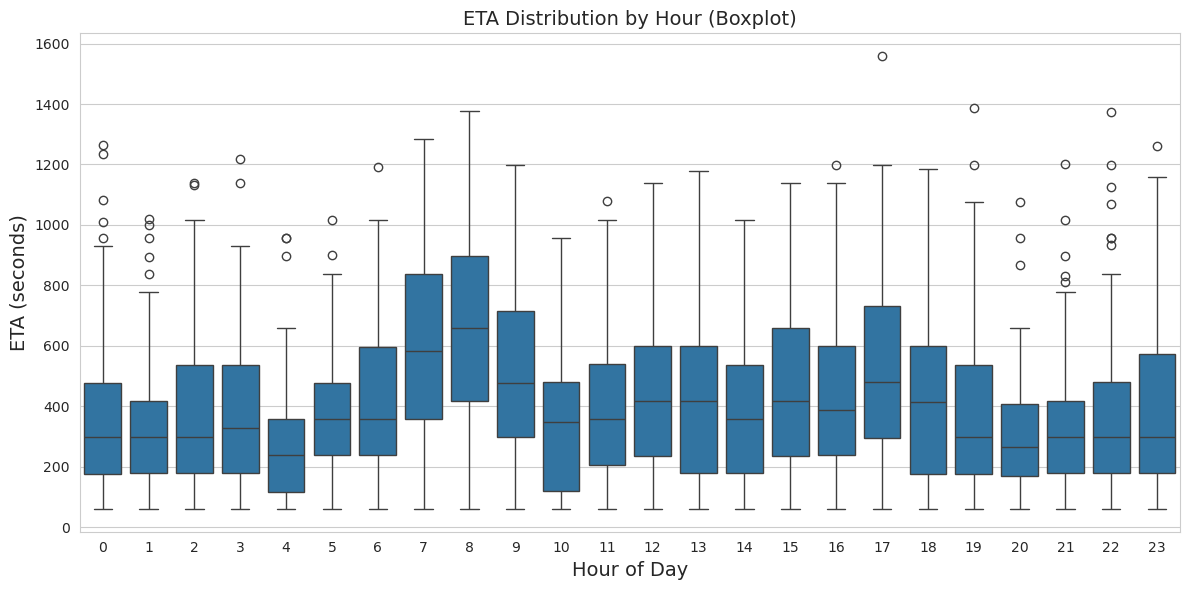

In [26]:
# Boxplot
plt.figure(figsize=(12, 6))

sns.boxplot(
    data=df_task4,
    x='order_hour',
    y='m_order_eta'
)

plt.title("ETA Distribution by Hour (Boxplot)", fontsize=14)
plt.xlabel("Hour of Day", fontsize=14)
plt.ylabel("ETA (seconds)", fontsize=14)
plt.tight_layout()
plt.show()

A key observation from the ETA boxplot is the presence of **long whiskers** in several hours of the day.  
Long whiskers indicate that a portion of orders experienced **significantly higher ETA than the typical range**, sometimes far beyond the interquartile spread. This suggests considerable **variability and instability** in driver assignment efficiency during these hours.

#### Possible Reasons for the Long-Whisker Pattern
- **Supply–demand imbalance:** During peak commuting hours or late at night, the number of active drivers may be insufficient to meet demand, forcing the system to assign drivers located much farther away.
- **Traffic congestion:** Heavy traffic in the morning and evening rush hours increases travel time for drivers to reach passengers, leading to extreme ETA values.
- **Sparse nighttime driver distribution:** Late-night periods often exhibit low driver density, causing large fluctuations in ETA when the nearest driver is far away.
- **Unpredictable assignment delays:** Inconsistencies in matching speed may cause some users to wait much longer before a driver is found.

#### Potential Solutions
- **Strengthen driver supply during critical hours**  
  Implement peak-hour incentives or guaranteed minimum earnings for drivers during 7–9 AM, 17 PM, and late-night periods to reduce extreme ETA outliers.
- **Improve pre-positioning using demand forecasting**  
  Predict high-demand areas and encourage drivers to move to those zones before spikes occur, reducing long-distance matches.
- **Enhance ETA prediction models**  
  Incorporate real-time traffic, road conditions, and driver density to more accurately reflect potential delays and reduce user frustration caused by misaligned expectations.
- **Optimize matching logic for high-variance hours**  
  Allow more flexible matching criteria (e.g., expanded radius) during peak times to avoid extreme wait times for certain passengers.

## Task 5 — Hexagon Spatial Analysis

In [27]:
import h3
import folium
import branca.colormap as cm

In [28]:
#! pip install h3
#! pip install folium
#! pip install shapely

In [29]:
df_hex = orders_failures.copy()

df_hex['h3_index'] = df_hex.apply(
    lambda row: h3.latlng_to_cell(row['origin_latitude'], 
                                  row['origin_longitude'], 
                                  8),
    axis=1
)

In [30]:
# calculate total order amount & failure order amount in each hex
hex_summary = (
    df_hex.groupby('h3_index')
          .agg(total_orders=('order_gk', 'count'),
               failed_orders=('failure_type', lambda x: x.notna().sum()))
          .reset_index()
)

In [31]:
hex_summary_sorted = hex_summary.sort_values('total_orders', ascending=False)
hex_summary_sorted['cumulative_pct'] = (
    hex_summary_sorted['total_orders'].cumsum() /
    hex_summary_sorted['total_orders'].sum()
)
hex_80pct = hex_summary_sorted[hex_summary_sorted['cumulative_pct'] <= 0.8]

print("Number of hexes covering 80% of orders:", len(hex_80pct))

Number of hexes covering 80% of orders: 23


In [34]:
# 1. Create the map centered at the average latitude and longitude
m = folium.Map(
    location=[df_hex['origin_latitude'].mean(),
              df_hex['origin_longitude'].mean()],
    zoom_start=12
)

# 2. Create color scale
max_failed = hex_summary['failed_orders'].max()
colormap = cm.linear.YlOrRd_09.scale(0, max_failed)

# 3. Draw H3 hexagons on the map
def add_hex_to_map(hex_id, value):
    # Updated H3 API: no geo_json argument
    boundary = h3.cell_to_boundary(hex_id)  # returns list of (lat, lng)

    folium.Polygon(
        locations=[(lat, lng) for lat, lng in boundary],
        fill=True,
        color=None,
        weight=0,
        fill_opacity=0.6,
        fill_color=colormap(value)
    ).add_to(m)

# 4. Add each hexagon
for _, row in hex_summary.iterrows():
    add_hex_to_map(row['h3_index'], row['failed_orders'])

# 5. Add legend
colormap.caption = "Number of Failed Orders"
colormap.add_to(m)

m.save("failed_orders_hex_map.html")
print("Map saved to failed_orders_hex_map.html")

Map saved to failed_orders_hex_map.html


In [35]:
import os

file_path = "failed_orders_hex_map.html"
m.save(file_path)

full_path = "file://" + os.path.abspath(file_path)
print("Map saved here:")
print(full_path)

Map saved here:
file:///home/jovyan/work/Insights-from-Failed-Orders/code/failed_orders_hex_map.html
